# **IMPORT**


In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
!pip install pydub
from pydub import AudioSegment
import os
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# **PATH of the DATASET**

In [ ]:
#Il faut avant tout connecter le drive pour que DATASET_PATH puisse avoir le chemin de l'accès !!
DATASET_PATH = '/content/drive/MyDrive/Eve 23-24/Projets/Lunettes pour aveugle/Codes/dataset_eve_projet_audio'

data_dir = pathlib.Path(DATASET_PATH)

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)
#Permet de vérifier ce qu'il y a dans le dataset audio

Commands: ['activer' 'allure' 'direction' 'donner' 'ecg' 'vitesse' 'obstacle'
 'panneau' 'lire' 'stop']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 4197
Number of examples per label: 406
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/Eve 23-24/Projets/Lunettes pour aveugle/Codes/dataset_eve_projet_audio/obstacle/obstacle.4dgacha7.ingestion-7c559b48d6-jqjkr.s28.wav', shape=(), dtype=string)


In [ ]:
train_files = filenames[:3358]
val_files = filenames[3358: 3358 + 419]
test_files = filenames[-419:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

#On divise de manière à faire 80%/10%/10% sur le training, validation et test set

Training set size 3358
Validation set size 419
Test set size 419


In [ ]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio_mono, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio_mono, axis=-1)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

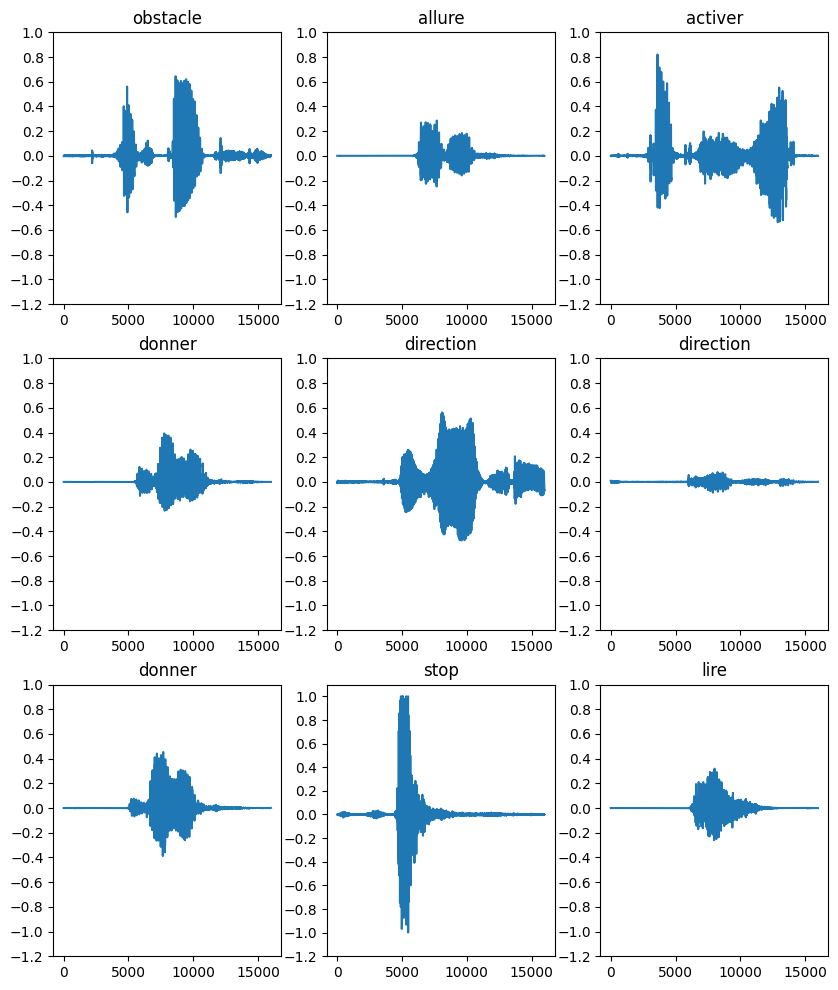

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for waveform, label in waveform_ds.take(5):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: direction
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

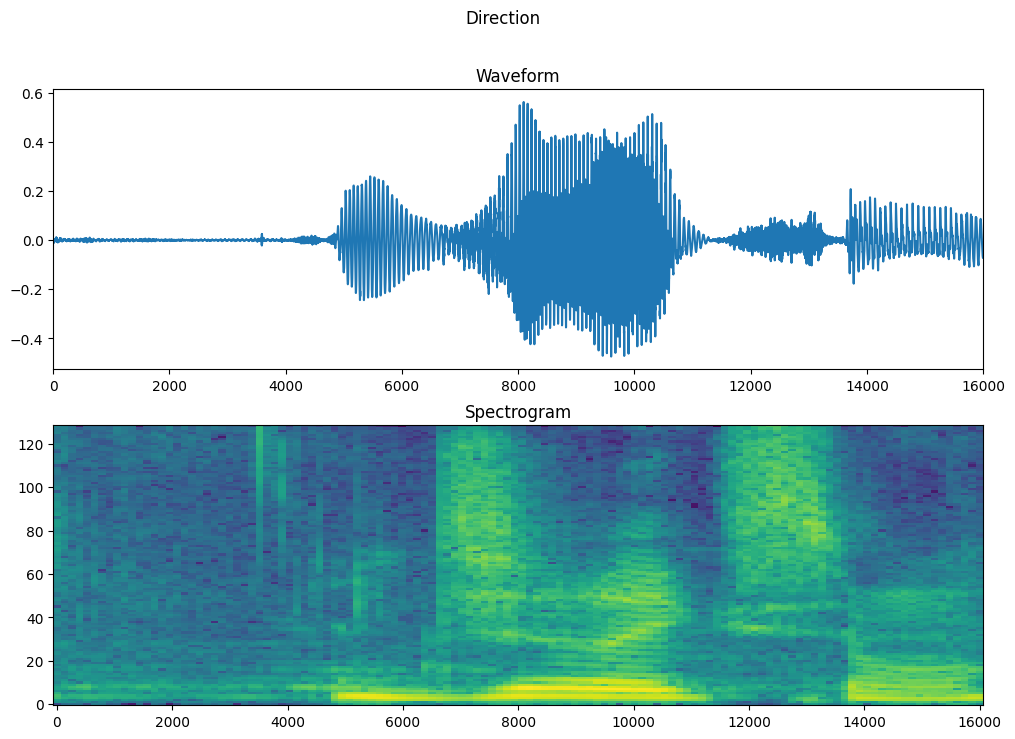

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id



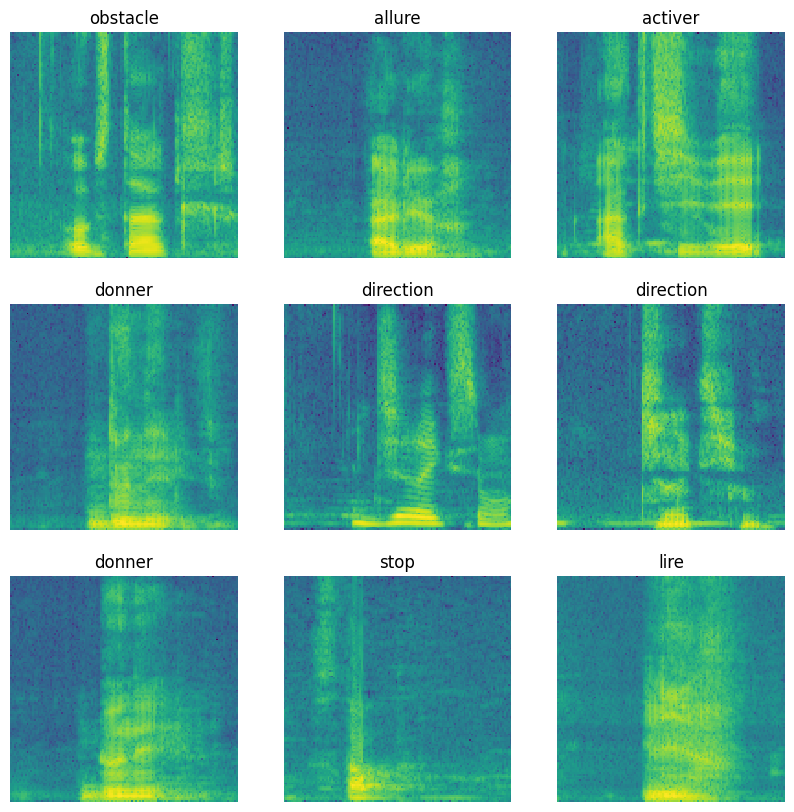

In [ ]:

spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(7):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization_4 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
53/53 [==============================] - 62s 1s/step - loss: 1.0418 - accuracy: 0.6644 - val_loss: 0.4738 - val_accuracy: 0.8067
Epoch 2/10
53/53 [==============================] - 9s 176ms/step - loss: 0.4954 - accuracy: 0.8297 - val_loss: 0.3256 - val_accuracy: 0.8496
Epoch 3/10
53/53 [==============================] - 12s 216ms/step - loss: 0.3175 - accuracy: 0.8672 - val_loss: 0.2742 - val_accuracy: 0.8568
Epoch 4/10
53/53 [==============================] - 12s 228ms/step - loss: 0.2671 - accuracy: 0.8773 - val_loss: 0.2559 - val_accuracy: 0.8663
Epoch 5/10
53/53 [==============================] - 12s 225ms/step - loss: 0.2400 - accuracy: 0.8853 - val_loss: 0.2487 - val_accuracy: 0.8544
Epoch 6/10
53/53 [==============================] - 10s 195ms/step - loss: 0.2179 - accuracy: 0.8895 - val_loss: 0.2316 - val_accuracy: 0.8759
Epoch 7/10
53/53 [==============================] - 12s 225ms/step - loss: 0.1878 - accuracy: 0.8970 - val_loss: 0.2435 - val_accuracy: 0.8663
Epo

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

14/14 [==============================] - 1s 39ms/step
Test set accuracy: 89%


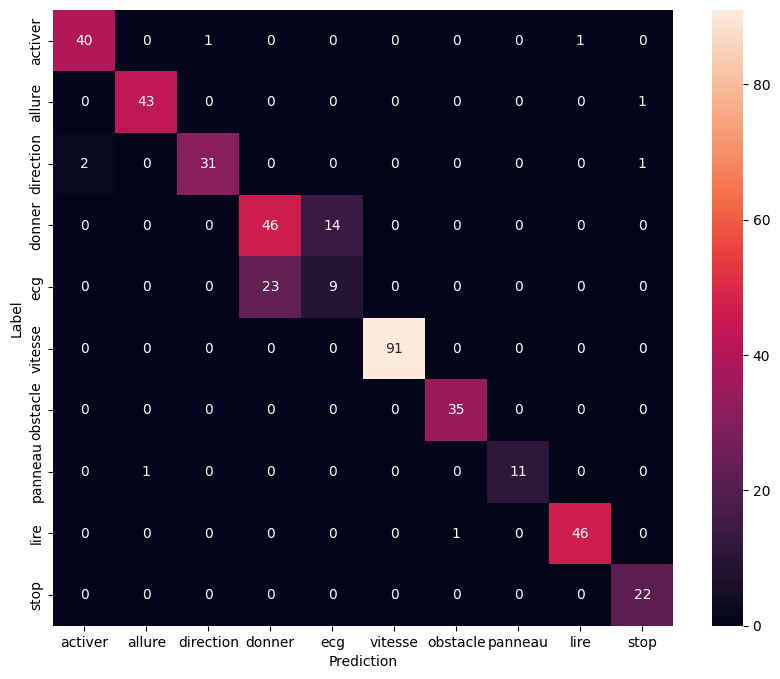

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

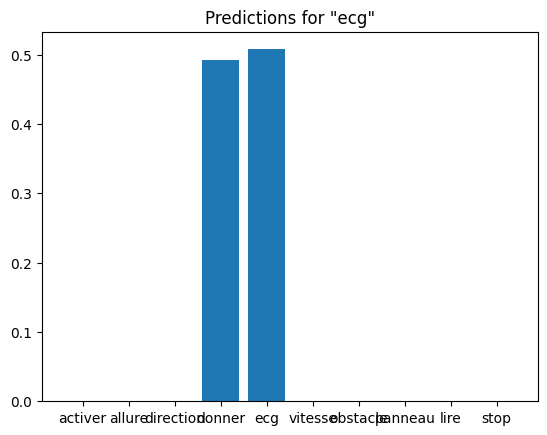

In [ ]:
sample_file = '/content/drive/MyDrive/Eve 23-24/Projets/Lunettes pour aveugle/Codes/dataset_eve_projet_audio/ecg/ecg.4ehkipfr.ingestion-69f5465f-c2vpc.s100.wav'
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  label_pred = np.argmax(prediction, axis=1)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
open("EVE_PROJET_AUDIO.tflite",  "wb").write(tflite_model)

1631824

In [ ]:
from tensorflow.lite.python.util import convert_bytes_to_c_source

source_text, header_text = convert_bytes_to_c_source(tflite_model,  "eve_project")

with  open('EVE_PROJET_AUDIO.h',  'w')  as  file:
    file.write(header_text)

with  open('EVE_PROJET_AUDIO.cc',  'w')  as  file:
    file.write(source_text)

In [ ]:
model.save("saved_model")


In [ ]:
!zip -r ./saved_model.zip ./saved_model/

  adding: saved_model/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/saved_model.pb (deflated 86%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/keras_metadata.pb (deflated 90%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/variables/variables.index (deflated 62%)


In [ ]:
loaded_model = models.load_model("saved_model")

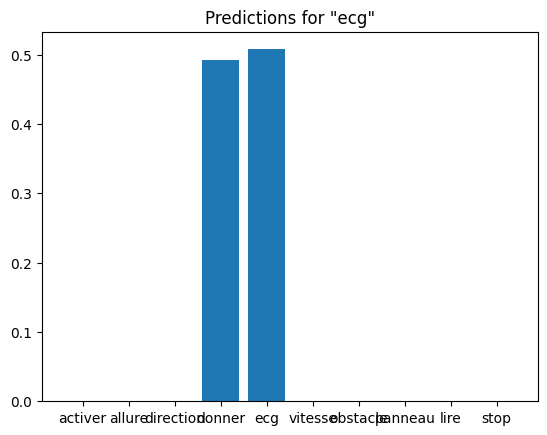

In [ ]:
for spectrogram, label in sample_ds.batch(1):
  prediction = loaded_model(spectrogram)
  label_pred = np.argmax(prediction, axis=1)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [ ]:
import wave

obj = wave.open(str(sample_file),'rb')
n_samples = obj.getnframes()
signal_wave = obj.readframes(n_samples)
signal_array = np.frombuffer(signal_wave, dtype=np.int16)
obj.close()

print(signal_array.shape) #sample

(16000,)


tf.Tensor(
[[ 0.5264387 -5.466887  -1.8903325 11.4519825 11.483413  -5.486907
  -1.6808162 -4.321402  -3.41981   -0.8415454]], shape=(1, 10), dtype=float32)


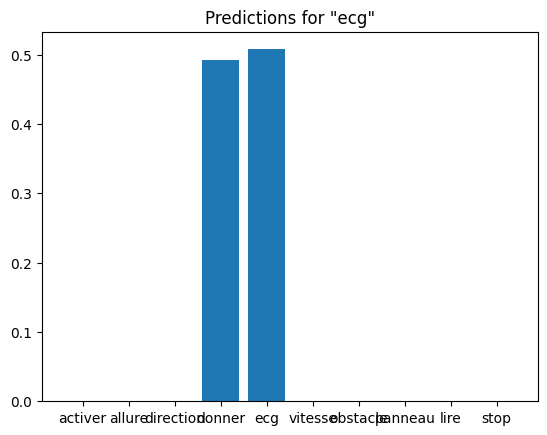

In [ ]:
waveform = signal_array / 32768
waveform = tf.convert_to_tensor(waveform, dtype = tf.float32)
spec = get_spectrogram(waveform)
spec = tf.expand_dims(spec, 0)
prediction = loaded_model(spec)
print(prediction)

label_pred = np.argmax(prediction, axis=1)
plt.bar(commands, tf.nn.softmax(prediction[0]))
plt.title(f'Predictions for "{commands[label[0]]}"')
plt.show()